In [29]:
# install transformer
!pip install transformers

In [30]:
!pip3 install emoji==0.6.0

In [31]:
import re
import torch
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoConfig, AutoModelForSequenceClassification
from transformers import BertTokenizer, BertForSequenceClassification, BertConfig
from torch.utils.data import DataLoader, TensorDataset, RandomSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from transformers import Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, classification_report

In [32]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [33]:
# Train data
train_df= pd.read_csv("/content/drive/MyDrive/Research NLP/research_data/sent_train.csv")
train_df.head(5)

,text,label
0,$BYND - JPMorgan reels in expectations on Beyo...,0
1,$CCL $RCL - Nomura points to bookings weakness...,0
2,"$CX - Cemex cut at Credit Suisse, J.P. Morgan ...",0
3,$ESS: BTIG Research cuts to Neutral https://t....,0
4,$FNKO - Funko slides after Piper Jaffray PT cu...,0


In [34]:
# Validate data
validate_df= pd.read_csv("/content/drive/MyDrive/Research NLP/research_data/sent_valid.csv")
validate_df.head(5)

,text,label
0,$ALLY - Ally Financial pulls outlook https://t...,0
1,"$DELL $HPE - Dell, HPE targets trimmed on comp...",0
2,$PRTY - Moody's turns negative on Party City h...,0
3,$SAN: Deutsche Bank cuts to Hold,0
4,$SITC: Compass Point cuts to Sell,0


In [35]:
# Clean text column
def clean_text(text):
    # Remove URLs
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)
    # Remove special characters
    # text = re.sub(r"[^\w\s]", "", text)
    # Lowercasing
    text = text.lower()
    return text

train_df['clean_text'] = train_df['text'].apply(clean_text)
validate_df['clean_text'] = validate_df['text'].apply(clean_text)

In [36]:
train_df.head(5)

,text,label,clean_text
0,$BYND - JPMorgan reels in expectations on Beyo...,0,$bynd - jpmorgan reels in expectations on beyo...
1,$CCL $RCL - Nomura points to bookings weakness...,0,$ccl $rcl - nomura points to bookings weakness...
2,"$CX - Cemex cut at Credit Suisse, J.P. Morgan ...",0,"$cx - cemex cut at credit suisse, j.p. morgan ..."
3,$ESS: BTIG Research cuts to Neutral https://t....,0,$ess: btig research cuts to neutral
4,$FNKO - Funko slides after Piper Jaffray PT cu...,0,$fnko - funko slides after piper jaffray pt cut


In [37]:
validate_df.head(5)

,text,label,clean_text
0,$ALLY - Ally Financial pulls outlook https://t...,0,$ally - ally financial pulls outlook
1,"$DELL $HPE - Dell, HPE targets trimmed on comp...",0,"$dell $hpe - dell, hpe targets trimmed on comp..."
2,$PRTY - Moody's turns negative on Party City h...,0,$prty - moody's turns negative on party city
3,$SAN: Deutsche Bank cuts to Hold,0,$san: deutsche bank cuts to hold
4,$SITC: Compass Point cuts to Sell,0,$sitc: compass point cuts to sell


In [38]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

def plot_class_dist_chart(df, run_mode):
    # Explore the distribution of classes
    # For train set
    train_class_distribution = Counter(df['label'])
    print("Class Distribution of train dataset:", train_class_distribution)

    # Convert the Counter object to a DataFrame for easier plotting
    class_dist_df = pd.DataFrame.from_dict(train_class_distribution, orient='index').reset_index()
    class_dist_df.columns = ['Class', 'Count']

    # Defining the plot size
    plt.figure(figsize=(5, 5))

    # Defining the values for x-axis, y-axis and creating the barplot
    plots = sns.barplot(x='Class', y='Count', data=class_dist_df)

    # Iterating over the bars one-by-one
    for bar in plots.patches:
        # Using Matplotlib's annotate function and
        # passing the coordinates where the annotation shall be done
        plots.annotate(format(bar.get_height(), '.2f'),
                      (bar.get_x() + bar.get_width() / 2,
                       bar.get_height()), ha='center', va='center',
                      size=12, xytext=(0, 5),
                      textcoords='offset points')

    # Setting the title for the graph
    plt.title("{} data class-wise data count".format(run_mode))

    # Finally showing the plot
    plt.show()


Class Distribution of train dataset: Counter({2: 6178, 1: 1923, 0: 1442})


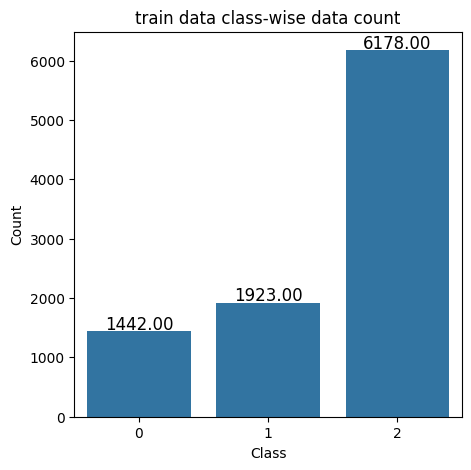

Class Distribution of train dataset: Counter({2: 1566, 1: 475, 0: 347})


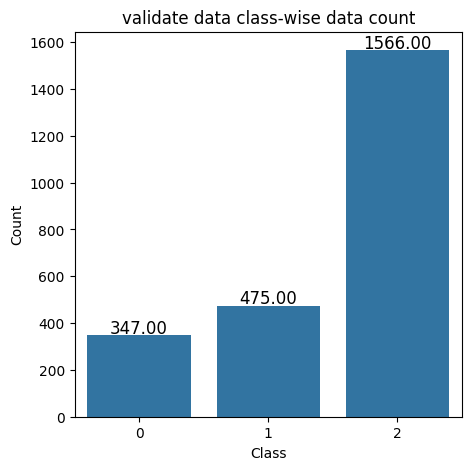

In [39]:
# Clean text column
counter=0
for df in [train_df, validate_df]:
    if counter == 0:
        run_mode="train"
    else:
        run_mode="validate"
    plot_class_dist_chart(df, run_mode)
    counter+=1

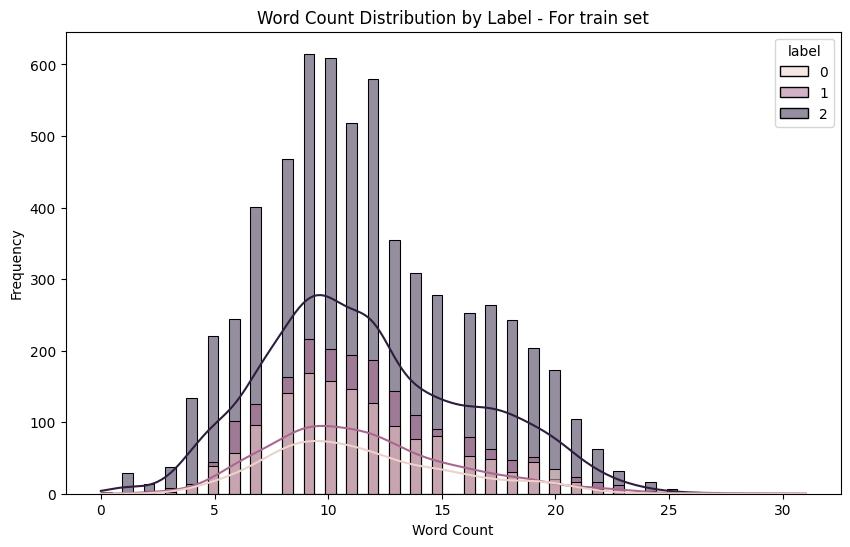

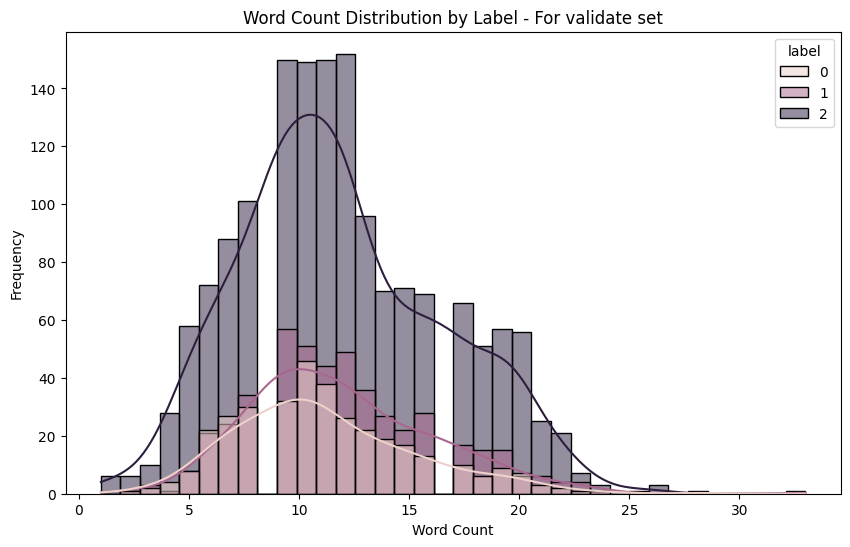

In [40]:
# Perform text data analysis - Word count distribution
def word_count_distribution(df,run_mode):
    df['word_count'] = df['clean_text'].apply(lambda x: len(str(x).split()))
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df, x='word_count', hue='label', kde=True)
    plt.title('Word Count Distribution by Label - For {} set'.format(run_mode))
    plt.xlabel('Word Count')
    plt.ylabel('Frequency')
    plt.show()
# Calling word count distribution function
word_count_distribution(train_df,"train")
word_count_distribution(validate_df,"validate")

Wordcloud on train set


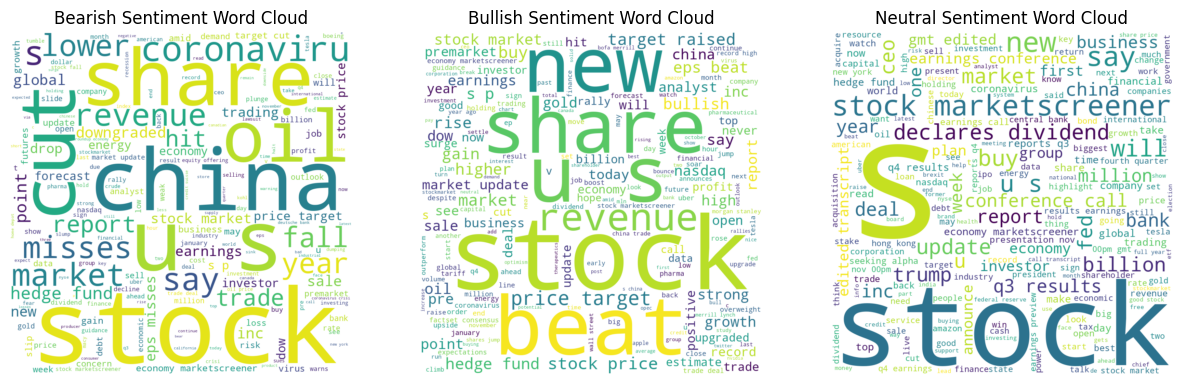

Wordcloud on validate set


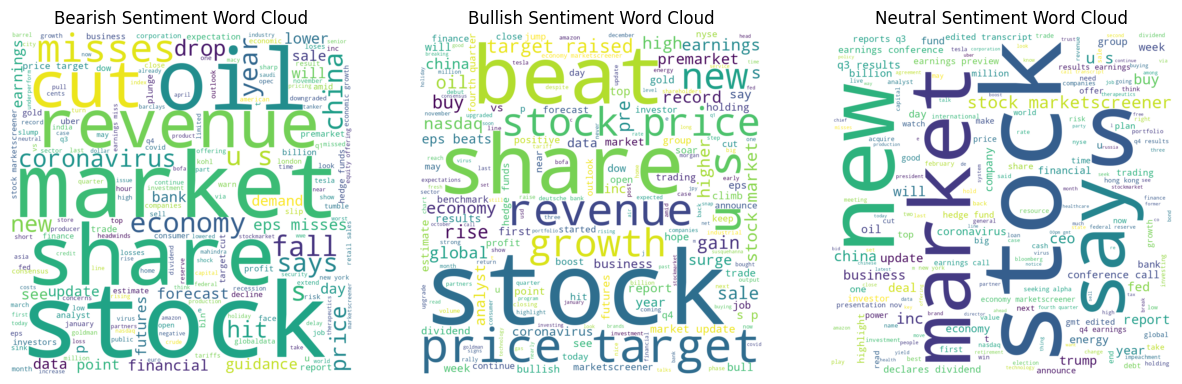

In [41]:
# Creating wordcloud for train set for three sentiment labels - Bearish, Bullish and Neutral tweets
def generate_word_cloud(df):
    bearish_tweets = " ".join(df[df['label'] == 0]['clean_text'])
    bullish_tweets = " ".join(df[df['label'] == 1]['clean_text'])
    neutral_tweets = " ".join(df[df['label'] == 2]['clean_text'])

    plt.figure(figsize=(15, 15))
    plt.subplot(1, 3, 1)
    wordcloud = WordCloud(width=1000, height=1000, background_color='white').generate(bearish_tweets)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title('Bearish Sentiment Word Cloud')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    wordcloud = WordCloud(width=1000, height=1000, background_color='white').generate(bullish_tweets)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title('Bullish Sentiment Word Cloud')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    wordcloud = WordCloud(width=1000, height=1000, background_color='white').generate(neutral_tweets)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title('Neutral Sentiment Word Cloud')
    plt.axis('off')

    plt.show()

# Generating wordclouds for train and validate datasets
counter=0
for df in [train_df,validate_df]:
    # setting title of plots
    if counter==0:
        print("Wordcloud on train set")
    else:
        print("Wordcloud on validate set")
    counter+=1
    generate_word_cloud(df)

In [44]:
train_final_df = train_df
validate_final_df = validate_df

In [46]:
train_final_df.head(5)

,text,label,clean_text,word_count
0,$BYND - JPMorgan reels in expectations on Beyo...,0,$bynd - jpmorgan reels in expectations on beyo...,9
1,$CCL $RCL - Nomura points to bookings weakness...,0,$ccl $rcl - nomura points to bookings weakness...,13
2,"$CX - Cemex cut at Credit Suisse, J.P. Morgan ...",0,"$cx - cemex cut at credit suisse, j.p. morgan ...",13
3,$ESS: BTIG Research cuts to Neutral https://t....,0,$ess: btig research cuts to neutral,6
4,$FNKO - Funko slides after Piper Jaffray PT cu...,0,$fnko - funko slides after piper jaffray pt cut,9


In [47]:
validate_final_df.head(5)

,text,label,clean_text,word_count
0,$ALLY - Ally Financial pulls outlook https://t...,0,$ally - ally financial pulls outlook,6
1,"$DELL $HPE - Dell, HPE targets trimmed on comp...",0,"$dell $hpe - dell, hpe targets trimmed on comp...",10
2,$PRTY - Moody's turns negative on Party City h...,0,$prty - moody's turns negative on party city,8
3,$SAN: Deutsche Bank cuts to Hold,0,$san: deutsche bank cuts to hold,6
4,$SITC: Compass Point cuts to Sell,0,$sitc: compass point cuts to sell,6


In [48]:
X = list(train_final_df['clean_text'])
y = list(train_final_df['label'])

In [49]:
# Split the data into training and validation sets
X_train, X_test,y_train,y_test = train_test_split(X,y, test_size=0.2, random_state=42)

In [50]:
import torch
from transformers import BertweetTokenizer, RobertaForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, TensorDataset, random_split
import matplotlib.pyplot as plt
import numpy
#from datasets import Dataset
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
# tested in transformers==4.18.0, pytorch==1.7.1
import torch
import transformers
torch.__version__, transformers.__version__

('2.4.0+cu121', '4.42.4')

In [51]:
torch.cuda.is_available()

True

In [52]:
# Load the BERTweet tokenizer and model
tokenizer = BertweetTokenizer.from_pretrained('vinai/bertweet-base')
model = RobertaForSequenceClassification.from_pretrained('vinai/bertweet-base', num_labels=3)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [53]:
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from transformers import get_linear_schedule_with_warmup

In [54]:
# Function to tokenize data
def tokenize_data(texts, labels, tokenizer):
    input_ids = []
    attention_masks = []
    for text in texts:
        encoded_dict = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=64,  # Adjust this based on your data
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(labels)
    return input_ids, attention_masks, labels

# Tokenize the data
train_input_ids, train_attention_masks, train_labels = tokenize_data(X_train, y_train, tokenizer)
test_input_ids, test_attention_masks, test_labels = tokenize_data(X_test, y_test, tokenizer)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [55]:
# Create TensorDataset
train_dataset = TensorDataset(train_input_ids, train_attention_masks, train_labels)
test_dataset = TensorDataset(test_input_ids, test_attention_masks, test_labels)

# Create DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Define optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
total_steps = len(train_dataloader) * 3  # Assuming 3 epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)



/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1 Step 0/478 Loss 1.15622079372406
Epoch 1 Step 10/478 Loss 0.9009750485420227
Epoch 1 Step 20/478 Loss 0.8308047652244568
Epoch 1 Step 30/478 Loss 0.9008226990699768
Epoch 1 Step 40/478 Loss 0.7470068335533142
Epoch 1 Step 50/478 Loss 0.5731818675994873
Epoch 1 Step 60/478 Loss 1.1593348979949951
Epoch 1 Step 70/478 Loss 0.6582738757133484
Epoch 1 Step 80/478 Loss 1.021485686302185
Epoch 1 Step 90/478 Loss 0.5721874237060547
Epoch 1 Step 100/478 Loss 0.7533499002456665
Epoch 1 Step 110/478 Loss 0.6270270347595215
Epoch 1 Step 120/478 Loss 0.8545764684677124
Epoch 1 Step 130/478 Loss 0.8103651404380798
Epoch 1 Step 140/478 Loss 0.757741391658783
Epoch 1 Step 150/478 Loss 0.38291501998901367
Epoch 1 Step 160/478 Loss 0.43514662981033325
Epoch 1 Step 170/478 Loss 0.5514320731163025
Epoch 1 Step 180/478 Loss 0.5480854511260986
Epoch 1 Step 190/478 Loss 0.5252543091773987
Epoch 1 Step 200/478 Loss 0.5549628734588623
Epoch 1 Step 210/478 Loss 0.461874395608902
Epoch 1 Step 220/478 Los

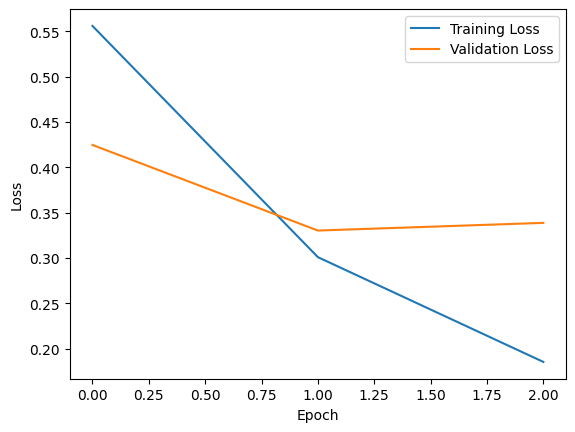

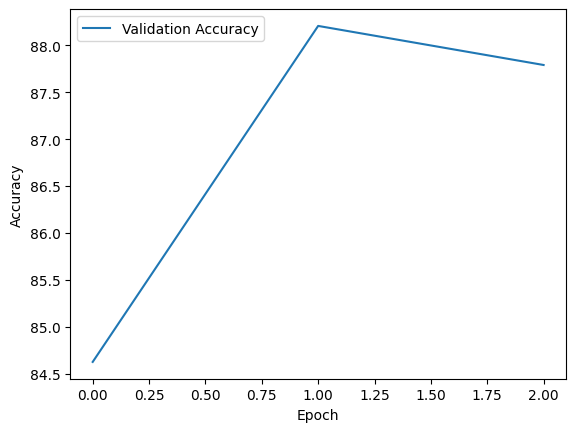

In [56]:
# Early stopping parameters
patience = 2  # Number of epochs to wait for improvement
best_val_loss = float('inf')
patience_counter = 0
model_save_path = '/content/drive/MyDrive/Research NLP/ensemble_wo_class_imbalance/best_model_BERTweet_wo_class_imbalance'

# Training and evaluation loop
training_stats = []
for epoch in range(3):  # specify the number of epochs
    model.train()
    total_train_loss = 0

    for step, batch in enumerate(train_dataloader):
        batch_input_ids, batch_attention_masks, batch_labels = batch
        optimizer.zero_grad()
        outputs = model(input_ids=batch_input_ids, attention_mask=batch_attention_masks, labels=batch_labels)
        loss = outputs.loss
        total_train_loss += loss.item()
        loss.backward()
        optimizer.step()
        scheduler.step()

        if step % 10 == 0:
            print(f"Epoch {epoch+1} Step {step}/{len(train_dataloader)} Loss {loss.item()}")

    avg_train_loss = total_train_loss / len(train_dataloader)

    # Validation loop
    model.eval()
    total_eval_accuracy = 0
    total_eval_loss = 0

    for batch in test_dataloader:
        batch_input_ids, batch_attention_masks, batch_labels = batch
        with torch.no_grad():
            outputs = model(input_ids=batch_input_ids, attention_mask=batch_attention_masks, labels=batch_labels)
        loss = outputs.loss
        logits = outputs.logits
        total_eval_loss += loss.item()

        preds = torch.argmax(logits, dim=1).flatten()
        accuracy = (preds == batch_labels).cpu().numpy().mean() * 100
        total_eval_accuracy += accuracy

    avg_val_accuracy = total_eval_accuracy / len(test_dataloader)
    avg_val_loss = total_eval_loss / len(test_dataloader)
    print(f"Epoch {epoch+1} Validation Accuracy: {avg_val_accuracy}")
    print(f"Epoch {epoch+1} Validation Loss: {avg_val_loss}")

    training_stats.append({
        'epoch': epoch + 1,
        'Training Loss': avg_train_loss,
        'Valid. Loss': avg_val_loss,
        'Valid. Accur.': avg_val_accuracy,
    })

    # Early stopping check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        # Save the best model
        model.save_pretrained(model_save_path)
        tokenizer.save_pretrained(model_save_path)
        print(f"Best model saved at epoch {epoch+1} with validation loss {avg_val_loss}")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1} with best validation loss {best_val_loss}")
            break

print("Training complete.")

# Load the best model for further evaluation or use
model = RobertaForSequenceClassification.from_pretrained(model_save_path)
tokenizer = BertweetTokenizer.from_pretrained(model_save_path)

# Plot the training and validation loss
train_loss_values = [stat['Training Loss'] for stat in training_stats]
val_loss_values = [stat['Valid. Loss'] for stat in training_stats]

plt.plot(train_loss_values, label="Training Loss")
plt.plot(val_loss_values, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Plot the validation accuracy
val_accuracy_values = [stat['Valid. Accur.'] for stat in training_stats]

plt.plot(val_accuracy_values, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [57]:
# Drop word_count column
validate_final_df.drop(columns=['word_count'], inplace=True)

In [58]:
validate_final_df.columns

Index(['text', 'label', 'clean_text'], dtype='object')

In [59]:
# Load the fine-tuned BERTweet model
bertweet_model = AutoModelForSequenceClassification.from_pretrained('/content/drive/MyDrive/Research NLP/ensemble_wo_class_imbalance/best_model_BERTweet_wo_class_imbalance')
bertweet_tokenizer = AutoTokenizer.from_pretrained('/content/drive/MyDrive/Research NLP/ensemble_wo_class_imbalance/best_model_BERTweet_wo_class_imbalance')

# Tokenize the validation data
texts = validate_final_df['clean_text'].tolist()
labels = validate_final_df['label'].tolist()

# Tokenize using BERTweet tokenizer
bertweet_input_ids, bertweet_attention_masks, labels = tokenize_data(texts, labels, bertweet_tokenizer)

# Create DataLoader for BERTweet
bertweet_dataset = TensorDataset(bertweet_input_ids, bertweet_attention_masks, labels)
bertweet_dataloader = DataLoader(bertweet_dataset, batch_size=16, shuffle=False)

# Function to get BERTweet outputs
def get_bertweet_outputs(model, dataloader):
    model.eval()
    outputs_list = []

    for batch in dataloader:
        batch_input_ids, batch_attention_masks, _ = batch

        with torch.no_grad():
            outputs = model(input_ids=batch_input_ids, attention_mask=batch_attention_masks)
        logits = outputs.logits
        outputs_list.extend(logits.cpu().numpy())

    return outputs_list

# Get BERTweet outputs
bertweet_outputs = get_bertweet_outputs(bertweet_model, bertweet_dataloader)
# Convert list to NumPy array
bertweet_outputs_array = np.array(bertweet_outputs)
bertweet_outputs_df = pd.DataFrame(bertweet_outputs_array, columns=[f'bertweet_output_{i}' for i in range(bertweet_outputs_array.shape[1])])

# Augment original data with BERTweet outputs
augmented_df = pd.concat([validate_final_df, bertweet_outputs_df], axis=1)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
finbert_model_path = "/content/drive/MyDrive/Research NLP/FinBERT_w_class_imbalance"

In [61]:
from transformers import BertTokenizer, BertModel, BertForSequenceClassification, AdamW
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
from transformers import get_linear_schedule_with_warmup
import os

# Tokenize augmented data for FinBERT
finbert_tokenizer = BertTokenizer.from_pretrained(finbert_model_path)

# Tokenize the augmented data
augmented_texts = augmented_df['clean_text'].tolist()
augmented_labels = augmented_df['label'].tolist()

def tokenize_augmented_data(texts, labels, tokenizer, max_length=64):
    input_ids = []
    attention_masks = []
    for text in texts:
        encoded_dict = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_length,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(labels)
    return input_ids, attention_masks, labels

finbert_input_ids, finbert_attention_masks, finbert_labels = tokenize_augmented_data(augmented_texts, augmented_labels, finbert_tokenizer)
# Convert bertweet_outputs to torch tensor
additional_features = torch.tensor(bertweet_outputs, dtype=torch.float32)

# Split dataset into training and validation sets
train_size = int(0.8 * len(finbert_labels))
val_size = len(finbert_labels) - train_size
train_dataset, val_dataset = random_split(
    TensorDataset(finbert_input_ids, finbert_attention_masks, finbert_labels, additional_features),
    [train_size, val_size]
)

# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Define FinBERT model with additional input for BERTweet outputs
class FinBERTWithBERTweet(torch.nn.Module):
    def __init__(self, finbert_model, bertweet_output_size):
        super(FinBERTWithBERTweet, self).__init__()
        self.bert = BertModel.from_pretrained(finbert_model_path)
        self.classifier = BertForSequenceClassification.from_pretrained(finbert_model_path, num_labels=3)
        self.dense = torch.nn.Linear(self.bert.config.hidden_size + bertweet_output_size, self.classifier.config.num_labels)

    def forward(self, input_ids, attention_mask, bertweet_outputs):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        sequence_output = outputs.last_hidden_state[:, 0, :]  # Take the [CLS] token output from the last hidden state
        combined_output = torch.cat((sequence_output, bertweet_outputs), dim=1)
        logits = self.dense(combined_output)
        return logits

# Load the FinBERT model
finbert_model = BertModel.from_pretrained(finbert_model_path)
classifier_model = BertForSequenceClassification.from_pretrained(finbert_model_path, num_labels=3)

# Initialize the ensemble model
ensemble_model = FinBERTWithBERTweet(finbert_model, bertweet_outputs_array.shape[1])

# Define optimizer
optimizer = AdamW(ensemble_model.parameters(), lr=2e-5, eps=1e-8)
total_steps = len(train_dataloader) * 3  # assuming 3 epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Early stopping parameters
patience = 2
best_val_loss = float('inf')
patience_counter = 0
model_save_path = '/content/drive/MyDrive/Research NLP/ensemble_wo_class_imbalance/ensemble_model/best_ensemble_model.pth'

# Training and evaluation loop
training_stats = []
for epoch in range(3):  # specify the number of epochs
    ensemble_model.train()
    total_train_loss = 0

    for step, batch in enumerate(train_dataloader):
        batch_input_ids, batch_attention_masks, batch_labels, batch_bertweet_outputs = batch

        optimizer.zero_grad()
        logits = ensemble_model(batch_input_ids, batch_attention_masks, batch_bertweet_outputs)
        loss = torch.nn.functional.cross_entropy(logits, batch_labels)
        total_train_loss += loss.item()
        loss.backward()
        optimizer.step()
        scheduler.step()

        if step % 10 == 0:
            print(f"Epoch {epoch+1} Step {step}/{len(train_dataloader)} Loss {loss.item()}")

    avg_train_loss = total_train_loss / len(train_dataloader)

    # Validation loop
    ensemble_model.eval()
    total_eval_loss = 0
    total_eval_accuracy = 0

    for batch in val_dataloader:
        batch_input_ids, batch_attention_masks, batch_labels, batch_bertweet_outputs = batch
        with torch.no_grad():
            logits = ensemble_model(batch_input_ids, batch_attention_masks, batch_bertweet_outputs)
        loss = torch.nn.functional.cross_entropy(logits, batch_labels)
        total_eval_loss += loss.item()

        preds = torch.argmax(logits, dim=1).flatten()
        accuracy = (preds == batch_labels).cpu().numpy().mean() * 100
        total_eval_accuracy += accuracy

    avg_val_accuracy = total_eval_accuracy / len(val_dataloader)
    avg_val_loss = total_eval_loss / len(val_dataloader)
    print(f"Epoch {epoch+1} Validation Accuracy: {avg_val_accuracy}")
    print(f"Epoch {epoch+1} Validation Loss: {avg_val_loss}")

    training_stats.append({
        'epoch': epoch + 1,
        'Training Loss': avg_train_loss,
        'Valid. Loss': avg_val_loss,
        'Valid. Accur.': avg_val_accuracy,
    })

    # Early stopping check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        # Save the best model
        torch.save(ensemble_model.state_dict(), model_save_path)
        print(f"Best model saved at epoch {epoch+1} with validation loss {avg_val_loss}")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1} with best validation loss {best_val_loss}")
            break

print("Training complete.")

# Load the best model for further evaluation or use
ensemble_model.load_state_dict(torch.load(model_save_path))
print("Model loaded successfully")


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
<ipython-input-61-94c8b4ebc86e>:36: UserWarning: Creating a tensor from a list of numpy.ndarrays is

Epoch 1 Step 0/120 Loss 0.8935060501098633
Epoch 1 Step 10/120 Loss 0.25668951869010925
Epoch 1 Step 20/120 Loss 0.41392216086387634
Epoch 1 Step 30/120 Loss 0.526252031326294
Epoch 1 Step 40/120 Loss 0.523215651512146
Epoch 1 Step 50/120 Loss 0.41883373260498047
Epoch 1 Step 60/120 Loss 0.2575179636478424
Epoch 1 Step 70/120 Loss 0.2188078761100769
Epoch 1 Step 80/120 Loss 0.4108804762363434
Epoch 1 Step 90/120 Loss 0.40489163994789124
Epoch 1 Step 100/120 Loss 0.5525394678115845
Epoch 1 Step 110/120 Loss 0.06774628907442093
Epoch 1 Validation Accuracy: 88.03571428571428
Epoch 1 Validation Loss: 0.3421045941611131
Best model saved at epoch 1 with validation loss 0.3421045941611131
Epoch 2 Step 0/120 Loss 0.050630781799554825
Epoch 2 Step 10/120 Loss 0.10027539730072021
Epoch 2 Step 20/120 Loss 0.26323652267456055
Epoch 2 Step 30/120 Loss 0.04283083975315094
Epoch 2 Step 40/120 Loss 0.08963936567306519
Epoch 2 Step 50/120 Loss 0.3492613732814789
Epoch 2 Step 60/120 Loss 0.0692586228251

<ipython-input-61-94c8b4ebc86e>:149: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ensemble_model.load_state_dict(torch.load(model_save_path))


Model loaded successfully


Inference data

In [62]:
validate_final_df.columns

Index(['text', 'label', 'clean_text'], dtype='object')

In [63]:
# Prediction function for the ensemble model
def predict_ensemble(model, dataloader):
    model.eval()
    predictions = []

    for batch in dataloader:
        batch_input_ids, batch_attention_masks, _, batch_bertweet_outputs = batch

        with torch.no_grad():
            logits = model(batch_input_ids, batch_attention_masks, batch_bertweet_outputs)
        preds = torch.argmax(logits, dim=1).flatten()
        predictions.extend(preds.cpu().numpy())

    return predictions

# Tokenize the validation data
validate_input_ids, validate_attention_masks, validate_labels = tokenize_augmented_data(texts, labels, finbert_tokenizer)

# Create DataLoader for the validation data
validate_dataset = TensorDataset(validate_input_ids, validate_attention_masks, validate_labels, additional_features)
validate_dataloader = DataLoader(validate_dataset, batch_size=16, shuffle=False)

# Perform predictions on the validation data
ensemble_predictions = predict_ensemble(ensemble_model, validate_dataloader)

# Display results
augmented_df['ensemble_predicted_label'] = ensemble_predictions
print(augmented_df)

import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Extract actual and predicted labels
y_true = augmented_df['label']
y_pred = augmented_df['ensemble_predicted_label']

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')
conf_matrix = confusion_matrix(y_true, y_pred)

# Display metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:\n", conf_matrix)

<ipython-input-61-94c8b4ebc86e>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


                                                   text  label  \
0     $ALLY - Ally Financial pulls outlook https://t...      0   
1     $DELL $HPE - Dell, HPE targets trimmed on comp...      0   
2     $PRTY - Moody's turns negative on Party City h...      0   
3                      $SAN: Deutsche Bank cuts to Hold      0   
4                     $SITC: Compass Point cuts to Sell      0   
...                                                 ...    ...   
2383  Stocks making the biggest moves midday: TD Ame...      2   
2384  Stocks making the biggest moves premarket: Fit...      2   
2385  Stocks making the biggest moves premarket: Hom...      2   
2386  Stocks making the biggest moves premarket: TD ...      2   
2387         TCO, NNVC, GPOR and JE among midday movers      2   

                                             clean_text  bertweet_output_0  \
0                 $ally - ally financial pulls outlook            2.315187   
1     $dell $hpe - dell, hpe targets trimmed on com

In [64]:
import pandas as pd
# Save data to location
augmented_df.to_csv("/content/drive/MyDrive/Research NLP/Results/ensemble_wo_class_imbalance/ensemble_wo_class_imbalance.csv", index=False)

Interpretation of model results

1. Accuracy (0.9468):

  The model achieves an accuracy of 94.7%, indicating that it correctly classifies the outcome for nearly 95% of the instances in the dataset. This high level of accuracy suggests that the model is generally very effective, though it may still benefit from minor adjustments to further improve performance.
2. Precision (0.9378):

  Precision is measured at 93.8%, which means that when the model predicts a positive class, it is correct 93.8% of the time. This indicates strong performance in minimizing false positives, which is especially important in scenarios where incorrect positive predictions could have significant consequences, such as in fraud detection or medical diagnostics.
3. Recall (0.9180):

  The recall value of 91.8% reflects the model's ability to correctly identify actual positive instances from the dataset. High recall is critical in contexts where it is essential to minimize false negatives, ensuring that the model captures most of the relevant cases.
4. F1 Score (0.9276):

  The F1 score, at 92.8%, represents a balanced metric that considers both precision and recall. This high F1 score indicates that the model effectively balances the trade-off between identifying true positives and minimizing false positives, making it well-suited for applications where both precision and recall are important.
5. Confusion Matrix:

  The confusion matrix provides insight into how the model performs across different classes:
  Class 1: The model correctly classifies 301 instances as Class 1, with 7 instances misclassified as Class 2 and 39 as Class 3. This suggests that while the model is quite accurate in identifying Class 1, there is a slight overlap with Class 3.
  Class 2: For Class 2, the model correctly predicts 433 instances, with 9 instances mistakenly identified as Class 1 and 33 as Class 3. The model shows strong performance in Class 2, though there is some misclassification with Class 3.
  Class 3: The model correctly identifies 1,527 instances as Class 3, with 16 incorrectly labeled as Class 1 and 23 as Class 2. This indicates that Class 3 is the most reliably predicted class, with fewer misclassifications compared to other classes.
6. Overall Summary:
  The model exhibits strong performance, with high accuracy, precision, recall, and F1 scores. The confusion matrix reveals that while the model is generally effective across all classes, there are minor misclassifications, particularly between Classes 1 and 3 and between Classes 2 and 3. These results suggest that the model is highly reliable and well-calibrated, but there may be opportunities for further refinement to reduce these misclassifications. Fine-tuning the model's parameters or incorporating additional training data could help to enhance its ability to distinguish between similar classes, thereby improving its overall effectiveness in real-world applications.